### INFO284 Machine Learning eksamen, vår 2024
av ppa007 og ....
levert 30.4.2024

#### Import og versjonskontroll for relevante biblioteker.

In [64]:
import sys
print("Python version: {}".format(sys.version))
import pandas as pd
print("pandas version: {}".format(pd.__version__))
import matplotlib
import matplotlib.pyplot as plt
print("matplotlib version: {}".format(matplotlib.__version__))
import numpy as np
print("NumPy version: {}".format(np.__version__))
import scipy as sp
print("SciPy version: {}".format(sp.__version__))
import IPython
print("IPython version: {}".format(IPython.__version__))
import sklearn
print("scikit-learn version: {}".format(sklearn.__version__))
import seaborn as sns
print("seaborn version: {}".format(sns.__version__))

Python version: 3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]
pandas version: 2.2.1
matplotlib version: 3.8.3
NumPy version: 1.26.4
SciPy version: 1.12.0
IPython version: 8.21.0
scikit-learn version: 1.4.1.post1
seaborn version: 0.13.2


#### Import av datasettet
Filen er kodet i UTF-8, så den vil bare fungere hvis du har riktig versjon av pandas.

In [65]:
filePath = 'elektronisk-rapportering-ers-2018-fangstmelding-dca-simple.csv'
df = pd.read_csv(filePath, encoding="UTF-8" , delimiter=";")
print(f"Før forbehandling har datasettet {df.shape[1]} kolonner og {df.shape[0]} rader")
df.head(5)

Før forbehandling har datasettet 45 kolonner og 305434 rader


,Melding ID,Meldingstidspunkt,Meldingsdato,Meldingsklokkeslett,Starttidspunkt,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),...,Art - FDIR,Art - gruppe (kode),Art - gruppe,Rundvekt,Lengdegruppe (kode),Lengdegruppe,Bruttotonnasje 1969,Bruttotonnasje annen,Bredde,Fartøylengde
0,1497177,01.01.2018,01.01.2018,00:00,31.12.2017,31.12.2017,00:00,"-60,35","-46,133",NaN,...,Antarktisk krill,506.0,Antarktisk krill,706714.0,5.0,28 m og over,9432.0,NaN,"19,87","133,88"
1,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,...,Hyse,202.0,Hyse,9594.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
2,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,...,Torsk,201.0,Torsk,8510.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
3,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,...,Blåkveite,301.0,Blåkveite,196.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
4,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,...,Sei,203.0,Sei,134.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"


#### Valg av mål og forbehandling
Våre valgte målvariabler er fangstene av hyse, torsk og sei som kontinuerlige verdier. Dette betyr at det er en kombinasjon av kolonnene ".....", som indikerer fangede arter, og "Rundvekt", som indikerer vekten av fangsten.

Først vil vi sette opp et frø som vi vil bruke i testing for å gjøre resultatene mer sammenlignbare på tvers av ulike modeller.

In [66]:
seed = 32

Neste steg er å ekskludere irrelevante kolonner.
- Fangstår: Datasettet er fra 2018, men inneholder noen rapporter fra 2017 da de ble rapportert inn etter nyttårsaften. Vi fjerner den fordi den bare inneholder 2 unike verdier, hvor over 99% av dem er bare en av dem.

In [67]:
value_counts = df['Fangstår'].value_counts()
print(value_counts)
df.drop(columns = ['Fangstår'], inplace= True)

Fangstår
2018    305416
2017        18
Name: count, dtype: int64


- Lengdegruppe (kode), Lengdegruppe, Bruttotonnasje 1969, Bruttotonnasje annen, Bredde, Fartøylengde: Disse kolonnene representerer liggnende informasjon om fangstbåten på forskjellige måter. Utifra det vi ønsker å predikere virker det mest hennsikstmessig å kun beholde bruttotonasje. Men for å gjøre det må vi først bevise likheten mellom de forskjellige variablene.

1. Bruttotonnasje 1969 og Bruttotonnasje annen: Når den ene kolonnen er tom har den andre data. Vi slår sammen begge kolonene og fjerner de radene hvor begge kolonnen er tomme.
2. Lengdegruppe (kode) og Lengdegruppe er den samme informasjonen.
3. Fartøylengde er en mer nyansert versjon av Lengdegruppe.
4. Fartøylengde og Bredde har en sterk korelasjon.
5. Fartøylengde og Bruttotonnasje har en sterk korelasjon.

In [68]:
b_nan = df['Bruttotonnasje 1969'].notnull() & df['Bruttotonnasje annen'].isnull()
a_nan = df['Bruttotonnasje annen'].notnull() & df['Bruttotonnasje 1969'].isnull()
both_nan = df['Bruttotonnasje 1969'].isnull() & df['Bruttotonnasje annen'].isnull()

print(f"""Kun Bruttotonnasje 1969 rader har verdi: {b_nan.sum()}
Kun Bruttotonnasje annen rader har verdi: {a_nan.sum()}
Begge kolonner har nan verdi: {both_nan.sum()}""")

df['Bruttotonnasje'] = df['Bruttotonnasje annen'].combine_first(df['Bruttotonnasje 1969'])
df.drop(columns=['Bruttotonnasje annen', "Bruttotonnasje 1969"], inplace=True)
df = df.dropna(subset=['Bruttotonnasje'])

Kun Bruttotonnasje 1969 rader har verdi: 227689
Kun Bruttotonnasje annen rader har verdi: 68458
Begge kolonner har nan verdi: 2971
(305434, 43)
(302463, 43)


In [88]:
value_counts = df.groupby(['Lengdegruppe (kode)', 'Lengdegruppe']).size().unstack(fill_value=0)
print(value_counts)

Lengdegruppe         15-20,99 m  21-27,99 m  28 m og over
Lengdegruppe (kode)                                      
3.0                       35893           0             0
4.0                           0       55436             0
5.0                           0           0        211134


In [83]:
df['Fartøylengde'] = df['Fartøylengde'].str.replace(',', '.').astype(float)
df['Bredde'] = df['Bredde'].str.replace(',', '.').astype(float)

In [84]:
min_max_values = df.groupby('Lengdegruppe')['Fartøylengde'].agg(['min', 'max'])
print(min_max_values)

                min     max
Lengdegruppe               
15-20,99 m    15.01   20.99
21-27,99 m    21.07   27.99
28 m og over  28.10  133.88


Correlation coefficient: 0.9444557211700517


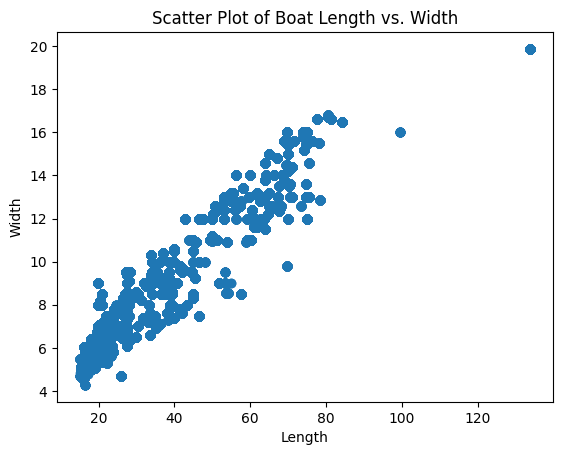

In [85]:
correlation = df['Fartøylengde'].corr(df['Bredde'])
print("Correlation coefficient:", correlation)

# Scatter plot of length vs. width
plt.scatter(df['Fartøylengde'], df['Bredde'])
plt.xlabel('Length')
plt.ylabel('Width')
plt.title('Scatter Plot of Boat Length vs. Width')
plt.show()

Correlation coefficient: 0.9237180814592622


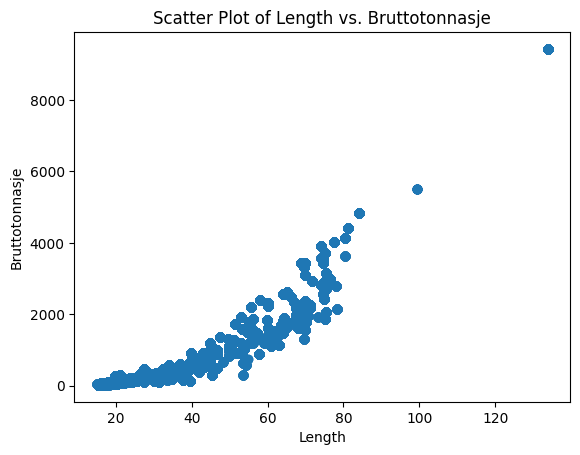

In [87]:
correlation = df['Fartøylengde'].corr(df['Bruttotonnasje'])
print("Correlation coefficient:", correlation)

# Scatter plot of length vs. width
plt.scatter(df['Fartøylengde'], df['Bruttotonnasje'])
plt.xlabel('Length')
plt.ylabel('Bruttotonnasje')
plt.title('Scatter Plot of Length vs. Bruttotonnasje')
plt.show()

In [89]:
df.drop(columns=["Lengdegruppe (kode)", "Lengdegruppe", "Bredde", "Fartøylengde"], inplace=True)
print(f"Datasettet har nå {df.shape[1]} kolonner og {df.shape[0]} rader")
df.head(5)

Datasettet har nå 39 kolonner og 302463 rader


,Melding ID,Meldingstidspunkt,Meldingsdato,Meldingsklokkeslett,Starttidspunkt,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),...,Hovedart FAO,Hovedart - FDIR (kode),Art FAO (kode),Art FAO,Art - FDIR (kode),Art - FDIR,Art - gruppe (kode),Art - gruppe,Rundvekt,Bruttotonnasje
0,1497177,01.01.2018,01.01.2018,00:00,31.12.2017,31.12.2017,00:00,"-60,35","-46,133",NaN,...,Antarktisk krill,2513.0,KRI,Antarktisk krill,2513.0,Antarktisk krill,506.0,Antarktisk krill,706714.0,9432.0
1,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,...,Hyse,1027.0,HAD,Hyse,1027.0,Hyse,202.0,Hyse,9594.0,1476.0
2,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,...,Hyse,1027.0,COD,Torsk,1022.0,Torsk,201.0,Torsk,8510.0,1476.0
3,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,...,Hyse,1027.0,GHL,Blåkveite,2313.0,Blåkveite,301.0,Blåkveite,196.0,1476.0
4,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,...,Hyse,1027.0,POK,Sei,1032.0,Sei,203.0,Sei,134.0,1476.0


- ?????